# Finetuning CNNs on medical image data

The objective of this homework is to use deep learning to recognize tumors in tissue image. We will use the [PCAM](https://github.com/basveeling/pcam) dataset consisting of "327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections".

**Note:** This homework will require intensive computations. It is thus preferable to use GPUs, for example with Google Colab (free access to GPUs).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time

In [46]:
torch.manual_seed(0)

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Data preprocessing

First, download the PCAM dataset using torchvision (see [documentation](https://pytorch.org/vision/stable/generated/torchvision.datasets.PCAM.html#torchvision.datasets.PCAM)). To keep computation times low, we will use the validation set (parameter `split='val'`) as train set (variable name `data_train`), and the test set (parameter `split='test'`) as test (variable name `data_test`). Plot the first 5 images of the train set corresponding to a tumor and the 5 first corresponding to healthy tissue. Can you see a difference?

In [69]:
data_train = torchvision.datasets.PCAM(root = './data', split='val')
data_test = torchvision.datasets.PCAM(root = './data', split='test')

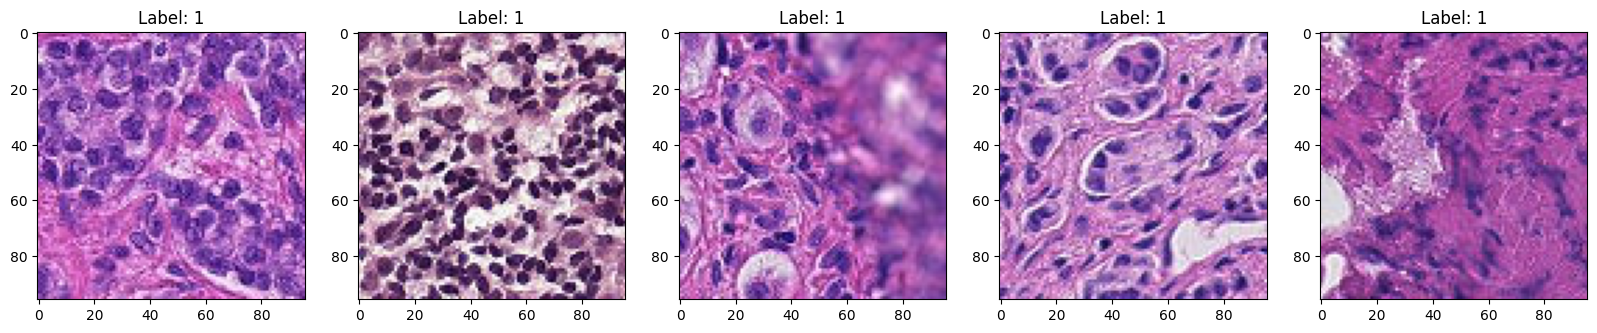

In [70]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(data_train[i][0])
    plt.title('Label: ' + str(data_train[i][1]))

plt.show()


Use `data_train.transform` and `data_test.transform` (see the [documentation](https://pytorch.org/vision/0.9/transforms.html)) to turn the images into tensors (of shape (3,96,96)) and normalize them using `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`, and verify that your data has the correct shape. How many elements are in your train and test sets?

In [79]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train.transform = img_transform
data_test.transform = img_transform


In [87]:
print(data_train[0][0].shape)
print(data_train[0][1])


torch.Size([3, 96, 96])
1


In [88]:
print("The train set has:", len(data_train), "elements.")
print("The test set has:", len(data_test), "elements.")

The train set has: 32768 elements.
The test set has: 32768 elements.


Now create a train and a test dataloader with a batch size of 64, and a random permutation for the train dataloader (with `shuffle=True`). How many mini-batches do you have?

In [89]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64, shuffle=True)

In [93]:
print("We have:", len(train_loader), "batches in the training set.")

We have: 512 batches in the training set.


## Training and testing loop

Write a function `train_model(model, dataloader, epochs)` that performs `epochs` training epochs using the Adam optimizer (with learning rate $10^{-3}$) on the cross entropy loss (using `nn.CrossEntropyLoss()`) for the model and data provided as input. **Note:** Remember to set the model to training mode using `model.train()`, and put the model and tensors on the correct device (CPU or GPU) by using `x.to(device)`. Plot the loss and accuracy of the model over the train set at each epoch.

In [144]:
def train_model(model, dataloader, epochs):
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    criterion = nn.CrossEntropyLoss()

    for e in range(epochs):
        running_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            y = torch.nn.functional.one_hot(y, num_classes=2)
            y = y.type(torch.float32)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print("Epoch {} - Training loss: {}".format(e+1, running_loss/len(dataloader)))

Now write a function `test_model(model,dataloader)` that plots the loss and accuracy of the model on the whole dataset.

In [155]:
def test_model(model, dataloader):

    model.to(device)
    model.eval()

    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    correct= 0
    with torch.no_grad():
        for x,y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            y = torch.nn.functional.one_hot(y, num_classes=2)
            y = y.type(torch.float32)
            total_loss += criterion(output,y)
            correct += (output.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    
    print("The overall loss of the model is:", total_loss.item())
    print("The accuracy of the model is:", correct/len(dataloader.dataset))

## Training a linear model

We now test a baseline model on our classification task: a simple linear model. Create a model using `nn.Sequential` that takes images, flatten them into vectors, and then compute a linear model out of it. The output should be 2-dimensional (to match our 2 classes). Then, train it for 2 epochs and test it on the test dataset.

In [151]:
%%time

linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(96*96*3, 2)
)

train_model(linear_model, train_loader, 2)

Epoch 1 - Training loss: 2.000085861887783
Epoch 2 - Training loss: 1.2370325402589515
CPU times: total: 1min 16s
Wall time: 1min 16s


In [156]:
test_model(linear_model, test_loader)

The overall loss of the model is: 722.9739990234375
The accuracy of the model is: 0.56884765625


## Fine-tuning a CNN model

We are now going to fine-tune a VGG model trained on [ImageNet](http://www.image-net.org/) (1.2M training images). The torchvision module comes with a zoo of pretrained popular CNN architectures. When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`. For next calls, the model will be directly read from there.

First, load the VGG model using `models.vgg16(weights='DEFAULT')` and print it to see its architecture.

In [159]:
model = models.vgg16(weights="DEFAULT")
model.children

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\User/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


<bound method Module.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

Note that the model is divided into two part: a **feature** section mainly made of convolutions and pooling layers, and a **classifier** part made of an MLP. We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

The idea of fine-tuning is that the features computed by VGG for Imagenet may be also good for other applications (e.g. for medical images). Replace the last layer of the `model_vgg.classifier` by a new linear layer that outputs 2 values (one for each class), and **freeze** all the other parameters of the VGG model by using `parameter.requires_grad=False` on all the parameters of the model except for the last layer.

In [164]:
model.classifier[-1] = nn.Linear(4096, 2, bias=True)

In [165]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [168]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier[-1].parameters():
    param.requires_grad = True

Now fine-tune the model by performing 2 epochs of training.

In [169]:
%%time
train_model(model, train_loader, 2)

Epoch 1 - Training loss: 0.48072305897949263
Epoch 2 - Training loss: 0.4649301193130668
CPU times: total: 1min 50s
Wall time: 2min 12s


In [170]:
test_model(model, test_loader)

The overall loss of the model is: 283.93438720703125
The accuracy of the model is: 0.778594970703125


## Speeding-up training by precomputing features

We are wasting a lot of time computing over and over the same quantities. Indeed, the first part of the VGG model (called `features` and made of convolutional layers) is frozen and never updated. Hence, we can precompute for each image in the dataset, the output of these convolutional layers as these outputs will always be the same during your training process.

Write a function `precompute_model(model, dataloader)` that takes a model and a dataloader as input, and returns a dataset containing the outputs of the model as input using `torch.utils.data.TensorData`.

In [173]:
def precompute_model(model, dataloader):
    model.to(device)
    model.eval()
    features = []
    labels = []
    for x,y in dataloader:
        x, y = x.to(device), y.to(device)
        output = model.features(x)
        features.append(output.cpu().numpy())
        labels.append(y.cpu().numpy())

    return torch.utils.data.TensorDataset(torch.from_numpy(np.concatenate(features)), torch.from_numpy(np.concatenate(labels)))

Use `precompute_model` to create a DataLoader for the train and test dataset with precomputed VGG features.

In [174]:
%%time
precompute_features = precompute_model(model, train_loader)

CPU times: total: 55 s
Wall time: 55.1 s


Finally, train a linear model on the our new precomputed features for 50 epochs. Is the model better?

In [176]:
%%time
linear_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(4608, 2)
)

train_loader_precompute = torch.utils.data.DataLoader(precompute_features, batch_size=64, shuffle=True)

train_model(linear_model, train_loader_precompute, 50)

Epoch 1 - Training loss: 0.34829414868727326
Epoch 2 - Training loss: 0.2872022007504711
Epoch 3 - Training loss: 0.2636907960259123
Epoch 4 - Training loss: 0.2560181007575011
Epoch 5 - Training loss: 0.246887356377556
Epoch 6 - Training loss: 0.2408206926920684
Epoch 7 - Training loss: 0.23479957203380764
Epoch 8 - Training loss: 0.23273037656326778
Epoch 9 - Training loss: 0.2306727898758254
Epoch 10 - Training loss: 0.22401772538432851
Epoch 11 - Training loss: 0.2222700747734052
Epoch 12 - Training loss: 0.2207928127681953
Epoch 13 - Training loss: 0.21767918158730026
Epoch 14 - Training loss: 0.2190476345276693
Epoch 15 - Training loss: 0.21583989282953553
Epoch 16 - Training loss: 0.2071361675261869
Epoch 17 - Training loss: 0.20448850781394867
Epoch 18 - Training loss: 0.20678185225551715
Epoch 19 - Training loss: 0.2083566567816888
Epoch 20 - Training loss: 0.20727795619313838
Epoch 21 - Training loss: 0.20765469301113626
Epoch 22 - Training loss: 0.20462736824993044
Epoch 23 

In [178]:
precompute_test = precompute_model(model, test_loader)

test_loader_precompute = torch.utils.data.DataLoader(precompute_test, batch_size=64, shuffle=True)

test_model(linear_model, test_loader_precompute)

The overall loss of the model is: 1096.2215576171875
The accuracy of the model is: 0.723602294921875
